# Optimizing Deep Q Learning with SHAP Explanations
Exploring Minimum Experience Replay Buffer Sizes for Reinforcement Learning

## Import Libraries

In [1]:
#basic
import random
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import datetime

#pytorch for gpu processing of ML model
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.autograd as autograd
from torch.autograd import Variable

#hide pytorch warnings (should eventually be resolved)
import warnings
warnings.filterwarnings("ignore")

#Simulations
import hrl_gym #simulate addiction
import gymnasium as gym

#!pip install shap
#github.com/slundberg/shap, 
#https://www.youtube.com/watch?v=Ty7qf3mV_Qc, 
#https://github.com/dynamik1703/gym_longicontrol/blob/master/Jupyter/LongiControl_SHAP.ipynb
# https://towardsdatascience.com/deep-learning-model-interpretation-using-shap-a21786e91d16

import shap 
shap.initjs() #call for each plot

## Agent's Brain (Deep Q-Learning)

### Neural Network Model

In [2]:
class Network(nn.Module):  
    def __init__(self, input_size, nb_action):
        #ref: https://discuss.pytorch.org/t/super-model-in-init/97426
        #super(Network, self).__init__()
        super().__init__() #pytorch's NN model
        self.input_size = input_size
        self.nb_action = nb_action
        self.fc1 = nn.Linear(input_size, 30)#arbitrarily chose 30 hidden layers
        self.fc2 = nn.Linear(30, nb_action)
    
    #base pytorch NN model runs and we override the
    #forward function with our own relu activation function
    def forward(self, state):
        x = F.relu(self.fc1(state))
        q_values = self.fc2(x)
        return q_values

### Experience Replay Model
This model is used for training our DQN model. It stores the transitions that the agent observes, allowing us to reuse this data later. By sampling from it randomly, the transitions that build up a batch are decorrelated. It has been shown that this greatly stabilizes and improves the DQN training procedure.

In [3]:
class ReplayMemory(): 
    def __init__(self, capacity):
        self.capacity = capacity
        self.memory = []
    
    def push(self, event):
        self.memory.append(event)
        if len(self.memory) > self.capacity:
            del self.memory[0] #forget first transition
    
    def sample(self, batch_size):
        samples = zip(*random.sample(self.memory, batch_size)) 
        return map(lambda x: Variable(torch.cat(x, 0)), samples) #tensor and gradient.
        #this contains sample of memory. get random sample from memory with given size
        # before list = [[state,action,reward], [state,action,reward]] zip*=> [[state], [action], [reward]]
        #the * operator unpacks a list and applies it to a function
        #a pytorch variable contains a tensor and a gradient. in order for pytorch to differenciate with respect to a tensor, we need a tensor and gradient
        # For each batch within a sample, we then have to concatenate it to the first dimension because 
        # everything needs to be aligned so state action and reward align to same time t
        # Lambda is used to do a short computation inline without def and if, etc.
        

### DQN Learning System
Comprised of a neural network model and a memory model. 
* The NN takes in observation of sensor data (brain chemicals) and chooses actions based on the relu activation function. 
* The agent will sample some of the sensor data and store in long term memory to be reused later for training. 
* We also use the Adam Optimisation algorithm. This is an extension to stocastic gradient desent to update weights of the neural network. 

In [4]:
class Dqn():
    def __init__(self, input_size, nb_action, gamma, capacity=100000, learning=0.001, temperature=100, sample_rate=100):
        self.gamma = gamma
        self.reward_window = []
        self.model = Network(input_size, nb_action)
        self.memory = ReplayMemory(capacity) #100k
        self.sample_rate = sample_rate
        self.optimizer = optim.Adam(self.model.parameters(), lr = learning)
        self.last_state = torch.Tensor(input_size).unsqueeze(0)
        self.last_action = 0
        self.last_reward = 0
        self.temp = temperature

        #create table for memory data collection
        self.df = pd.DataFrame(columns=['outputs'])

    # select action for x duration
    def select_action(self, state):
        #softmax converts numbers into probabilities
        #Q values are the output of the neural network
            #view q values
        q_value_tensor = self.model(Variable(state, volatile = True)) 
        q_values = [q_value.detach().numpy() for q_value in q_value_tensor]
            #print(q_values)
            #viz q value for each action, (T value by user choice)
            #pie chart 0/1 #seperate action
        # Temperature value = 100. closer to zero the less sure the NN will be to taking the action
        probs = F.softmax(self.model(Variable(state, volatile = True))*self.temp) # T=100
        
        action_prob = [prob.detach().numpy() for prob in probs]

        action = probs.multinomial(num_samples=1) # action taken
        #q_values[0][action] #quality of taking action in state
        #action_prob[0][action] #probability of taking action

        #return the action taken, q values and probabilities of taking action given state.
        #return action.data[0,0], q_values[0][action], action_prob[0][action]
        return action.data[0,0], q_values, action_prob
    
    #When ai reaches a new state we update everything
    #update action, last action becomes the new action but also the last state becomes the new state and last reward becomes the new state
    # we then get this new transition and update our reward window to track training progress and exploration
    def update(self, reward, new_signal):
        new_state = torch.Tensor(new_signal).float().unsqueeze(0)
        self.memory.push((self.last_state, new_state, torch.LongTensor([int(self.last_action)]), torch.Tensor([self.last_reward])))
        action, q, p = self.select_action(new_state)
        if len(self.memory.memory) > self.sample_rate: #100
            batch_state, batch_next_state, batch_action, batch_reward = self.memory.sample(self.sample_rate) 
            self.learn(batch_state, batch_next_state, batch_reward, batch_action)
            #X=batch_state and y=batch_next_state
        self.last_action = action
        self.last_state = new_state
        self.last_reward = reward
        self.reward_window.append(reward)
        #if len(self.reward_window) > 1000:
        #    del self.reward_window[0]
        return action, q, p
    
    #to train our AI
    #forward propagation then backproagation
    # get our output, target, compare our output to the target to compute the loss error
    # backproagate loss error into the nn and use stochastic gradient descent we update the weights according to how much they contributed to the loss error
    def learn(self, batch_state, batch_next_state, batch_reward, batch_action):
        #when we pass in batch state the output will be all possible actions
        # we use gather passing in 1 and batch action because we only want the chosen action
        # however batch_state has a fake dimention from unsqueeze in __init__ of NN and batch action doesn't
        outputs = self.model(batch_state).gather(1, batch_action.unsqueeze(1)).squeeze(1) #pass state into neural network input layer., gather outputs a new tensor. input dimension
        #gets the q values for all the next states with respect to action (i.e 1) then get the max
        next_outputs = self.model(batch_next_state).detach().max(1)[0]
        target = self.gamma*next_outputs + batch_reward
        td_loss = F.smooth_l1_loss(outputs, target)
        self.optimizer.zero_grad()
        td_loss.backward(retain_graph = True)
        self.optimizer.step()
    
    def score(self):
        #return sum(self.reward_window)/(len(self.reward_window)+1.0)
        return sum(self.reward_window)
    
    def save(self):
        torch.save({'state_dict': self.model.state_dict(),
                    'optimizer' : self.optimizer.state_dict(),
                   }, 'last_brain.pth')
    def load(self):
        if os.path.isfile('last_brain.pth'):
            print("=> loading checkpoint... ")
            checkpoint = torch.load('last_brain.pth')
            self.model.load_state_dict(checkpoint['state_dict'])
            self.optimizer.load_state_dict(checkpoint['optimizer'])
            print("done !")
        else:
            print("no checkpoint found...")

## Experiments

### 1. Addiction Simulator
Simulating cocaine addiction by varying a Homeostatic setpoint an agent uses to do Homeostatic Reinforcement Learning. This is a third party custom environment adapted for Gym to allow a deep Q learning to learn how to solve a complex real world problem. It is based on Mehdi Keramati's 'escalation of cocaine-seeking in the homeostatic reinforcement learning framework'. This framework was created by Keramati in March 2013 using Python 2.6 to mimic experimental cocaine data with mice.

#### Build Third Party Custom Gym Environment

In [5]:
env = gym.make('HRLSim-v0', render_mode="notebook", time_hours=4) #time_hours
observation = env.reset()[0]
reward = env.reward
done = False

Simulation Reset.
Total Time: 4 hrs.
Total Epochs: 3600.0

#### Create the Deep Q-Learning Agent

In [6]:
# Agent Brain - a neural network that represents our Q-function
s = 2 # sensors/states/observations
a = env.action_space.n # actions
g = 0.9 #gamma
c = 100000 #experience replay capacity
m = 100 #memory sampling
l = 0.001 #learning rate
t = 100 #softmax policy temperature rate

agent = Dqn(s,a,g,c,l,t, m)

#### Run simulation with Agent

In [7]:
while not done:
    env.render()
    action, qValues, transitionProbs = agent.update(reward, observation)
    observation, reward, done, truncated, info = env.step(action)
env.close() #close simulation

** Current Time: 4.0 hrs, Epoch Left: 0.0 hrs, **
Last Action: In-Active Lever,
Current Homeostatic Variable: 348.2144, Current Homeostatic Setpoint: 199.9973,
 Reward Received: -2.8, Total Score: -150224.67

Simulation Ended.

#### Plot Results

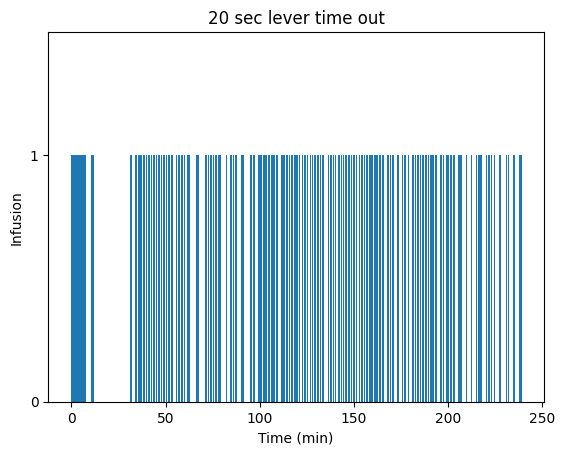

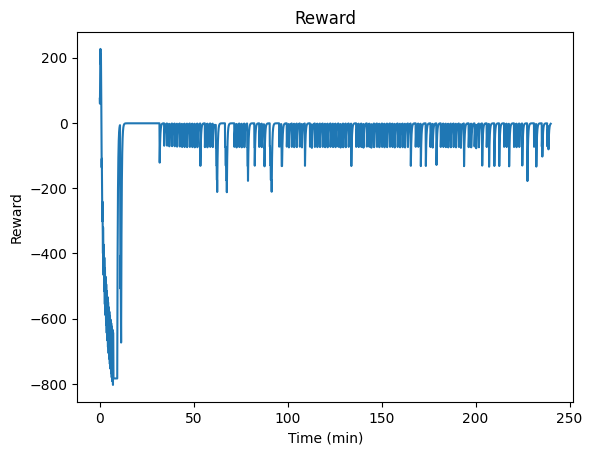

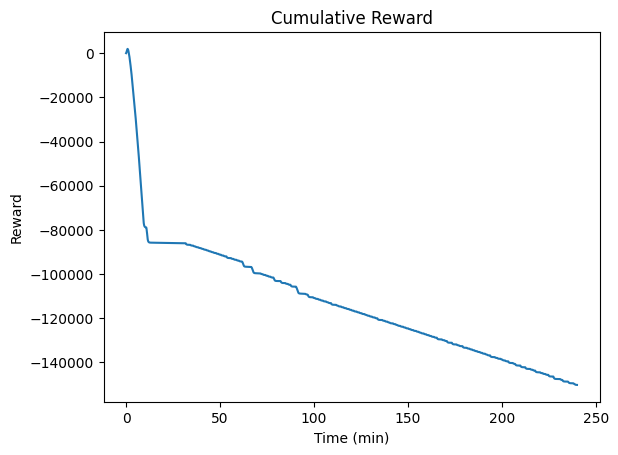

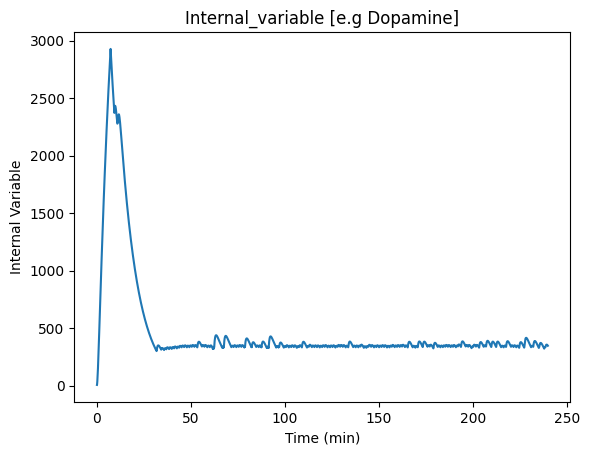

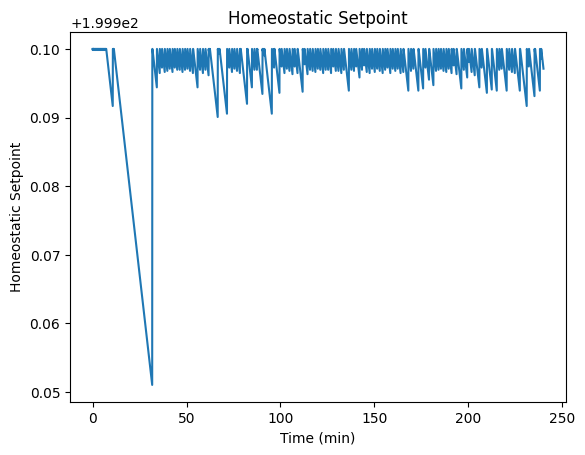

In [8]:
#plot our results
# Convert epoch values to seconds
env.df['time_sec'] = env.df['epoch'] * 4 / 60

# Filter the data to only include 'Active Lever' actions
active_lever_data = env.df[env.df['action'] == 'Active Lever']
active_lever_data['active_lever'] = active_lever_data['action'].apply(lambda x: 1 if x == 'Active Lever' else 0)

# Create a bar chart of the 'Active Lever' action occurrence as a time series
plt.bar(active_lever_data['time_sec'], active_lever_data['active_lever'])

plt.xlabel('Time (min)')
plt.ylabel('Infusion')
plt.title('20 sec lever time out')
# Set x-axis limits to 0 and 40 minutes
#plt.xlim([0, 35])
plt.ylim([0, 1.5])
# Set y-tick values and labels
plt.yticks([0, 1], ['0', '1'])
plt.show()

# Convert epoch values to seconds
plt.title("Reward")
plt.xlabel("Time (min)")
plt.ylabel("Reward")
plt.plot(env.df['time_sec'], env.df["reward"])
plt.show()

plt.title("Cumulative Reward")
plt.xlabel("Time (min)")
plt.ylabel("Reward")
plt.plot(env.df['time_sec'], env.df["score"])
plt.show()

plt.title("Internal_variable [e.g Dopamine]")
plt.xlabel("Time (min)")
plt.ylabel("Internal Variable")
plt.plot(env.df['time_sec'], env.df["internal_variable"])
plt.show()

plt.title("Homeostatic Setpoint")
plt.xlabel("Time (min)")
plt.ylabel("Homeostatic Setpoint")
plt.plot(env.df['time_sec'], env.df["homeostatic_setpoint"])
plt.show()

#### Generate Dataset
View Synthetic Dataset

In [9]:
#env.df.head(250)
#env.df.iloc[100:150] #when hit is taken
env.df.iloc[3041:3050]

,epoch,action,epochs_inactive,internal_variable,homeostatic_setpoint,reward,score,time_sec
3041,3041,In-Active Lever,0,348.185987,199.99776,-4.233579,-139529.830756,202.733333
3042,3042,In-Active Lever,1,346.693892,199.99760,-3.586863,-139533.417619,202.800000
3043,3043,In-Active Lever,2,345.098817,199.99744,-3.069490,-139536.487110,202.866667
3044,3044,In-Active Lever,3,343.415094,199.99728,-2.655592,-139539.142702,202.933333
3045,3045,In-Active Lever,4,341.655321,199.99712,-2.324474,-139541.467176,203.000000
3046,3046,In-Active Lever,0,339.830570,199.99696,-2.059579,-139543.526755,203.066667
3047,3047,In-Active Lever,1,337.950572,199.99680,-1.847663,-139545.374418,203.133333
3048,3048,In-Active Lever,2,336.023876,199.99664,-1.678131,-139547.052549,203.200000
3049,3049,In-Active Lever,3,334.057992,199.99648,-1.542505,-139548.595053,203.266667


Export Dataset

In [10]:
x = datetime.datetime.now()
file_name = "./datasets/" + str(x.year) + "_" + str(x.month) + "_" + str(x.day) + "_" + str(x.strftime("%H")) + "_" + str(x.strftime("%M")) + "_" + str(x.strftime("%S")) + ".csv"
#env.df.to_csv(file_name, index=False, encoding='utf-8')

#### Save Deep Q Model

In [11]:
agent.save()

#### SHAP Explain Model
SHAP Values are one of the most used ways of explaining the model and understanding how the features of the data are related to the outputs. It is derived from coalitional game theory to provide a way to distribute the “payout” across the features fairly. One of the biggest advantages of SHAP Values is that they provide both global and local explainability.

Captum is a library to help interpret PyTorch models. A neural network model interpretation can be used to understand the feature importance, dominant layer identification, and dominant neuron identification for Q learning.

The primary attribution layer provides integrated gradients, gradient shapely additive explanations (SHAP), saliency, etc., to interpret the model in a more effective way.

In [23]:
agent.memory.memory[0]  #last_state, new_state, last_action, last_reward, e.g [0.0, 0.0], [0.0. 199.9840], 0, 0.0

(tensor([[1.0194e-38, 5.9694e-39]]),
 tensor([[  0., 200.]]),
 tensor([0]),
 tensor([0.]))

In [31]:
zipped_memory_sample = zip(*random.sample(agent.memory.memory, 10))

"""#sample
(
[[241.1019, 200.0000]],
[[244.9151, 199.9998]],
[1],
[-53.4884]
)
"""
#print(list(zipped_memory_sample))
#[(tensor([[252.1920, 200.0000]]),), (tensor([[255.9023, 199.9998]]),), (tensor([1]),), (tensor([-56.5653]),)]

'#sample\n(\n[[241.1019, 200.0000]],\n[[244.9151, 199.9998]],\n[1],\n[-53.4884]\n)\n'

In [32]:
mapped = map(lambda x: Variable(torch.cat(x, 0)), zipped_memory_sample)
#print(list(mapped))
#'#sample\n(\n[[241.1019, 200.0000]],\n[[244.9151, 199.9998]],\n[1],\n[-53.4884]\n)\n'
#[tensor([[246.0236, 199.9952]]), tensor([[250.4203, 200.0000]]), tensor([2]), tensor([-1.0702])]
#batch_state, batch_next_state, batch_action, batch_reward

In [33]:
batch_state, batch_next_state, batch_action, batch_reward = map(lambda x: Variable(torch.cat(x, 0)), zipped_memory_sample)

In [34]:
batch_state

tensor([[359.8259, 199.9958],
        [338.6303, 200.0000],
        [397.5226, 199.9949],
        [401.5535, 199.9994],
        [381.7710, 199.9979],
        [337.1804, 199.9968],
        [351.9342, 199.9997],
        [342.7143, 199.9998],
        [344.7974, 199.9984],
        [348.3209, 199.9987]])

In [35]:
batch_next_state

tensor([[357.6745, 199.9957],
        [341.9297, 199.9998],
        [395.0358, 199.9947],
        [409.7484, 199.9992],
        [380.9917, 199.9978],
        [341.2682, 200.0000],
        [354.1189, 199.9995],
        [345.5170, 199.9997],
        [343.9385, 199.9982],
        [347.9144, 199.9986]])

In [36]:
batch_action

tensor([1, 1, 1, 1, 1, 2, 1, 1, 1, 1])

In [37]:
batch_reward

tensor([ -1.3941, -73.9222,  -1.1663, -87.2663,  -8.1979,  -1.8498, -49.1729,
        -60.1230,  -8.7497, -13.2045])

In [39]:

# DeepExplainer to explain predictions of the model
explainer = shap.DeepExplainer(agent.model, batch_next_state) #training data

# compute shap values
shap_values = explainer.shap_values(batch_next_state) #test data

#from captum.attr import IntegratedGradients
#from captum.attr import LayerConductance
#from captum.attr import NeuronConductance

#ig = IntegratedGradients(agent.model)
#test_input_tensor.requre_grad_()
#attr, delta = ig.attribute(test_input_tensor, target 1, return_convergence_delta=True)

In [40]:
shap_values

[array([[ 5.26020479e+00, -4.74288754e-05],
        [ 1.12207422e+01,  5.91014978e-04],
        [-8.88372421e+00, -1.94762019e-04],
        [-1.44535112e+01,  4.92792751e-04],
        [-3.56702876e+00,  2.70623743e-04],
        [ 1.14711914e+01,  6.14401128e-04],
        [ 6.60626888e+00,  5.41903893e-04],
        [ 9.86272240e+00,  5.65290102e-04],
        [ 1.04602709e+01,  3.45459615e-04],
        [ 8.95513153e+00,  3.94570699e-04]]),
 array([[-1.14692726e+01, -2.12761178e-03],
        [-5.14083004e+00, -8.37039552e-04],
        [-2.64862118e+01, -2.42543640e-03],
        [-3.23997879e+01, -1.03558914e-03],
        [-2.08413563e+01, -1.48468954e-03],
        [-4.87492323e+00, -7.89765734e-04],
        [-1.00401249e+01, -9.36314347e-04],
        [-6.58267355e+00, -8.89040704e-04],
        [-5.94824171e+00, -1.33341353e-03],
        [-7.54628229e+00, -1.23413862e-03]]),
 array([[ 6.01448059e-01, -7.09185144e-03],
        [ 2.66974392e+01,  3.13218986e-03],
        [-6.13224602e+01, -9

#### Create Deep Q-Learning Agent

### 2. Cartpole Simulator
Simulate balancing a pole

#https://pytorch.org/tutorials/intermediate/reinforcement_q_learning.html
env = gym.make('CartPole-v1', render_mode='human')
observation = env.reset()[0]

print(env.action_space.n)
print(env.action_space)
print(env.observation_space.shape[0])
print(observation)

# Agent Brain - a neural network that represents our Q-function
s = env.observation_space.shape[0] # sensors
a = env.action_space.n # actions
g = 0.9 #gama
c = 100000, 
l = 0.001, 
t = 100
agent = Dqn(s,a,g,c,l,t)
reward = 0

for _ in range(1000):
    #env.render()
    action, qValues, transitionProbs = agent.update(reward, observation)
    observation, reward, terminated, truncated, info = env.step(action.item())

    if terminated or truncated:
        observation, info = env.reset()
env.close()

### 3. Lunar Lander Simulator
Simulating landing on the moon with a LunarLander

env = gym.make("LunarLander-v2", render_mode="human")
observation, info = env.reset(seed=42)
reward = 0

# Agent Brain - a neural network that represents our Q-function
s = env.observation_space.shape[0] # sensors
a = env.action_space.n # actions
g = 0.9 #gama
c = 100000, 
l = 0.001, 
t = 100
agent = Dqn(s,a,g,c,l,t)

for _ in range(1000):
   env.render()
   action, qValues, transitionProbs = agent.update(reward, observation)
   observation, reward, terminated, truncated, info = env.step(int(action))
   if terminated or truncated:
      observation, info = env.reset()
env.close()

## References


## Appendix

### Installation Instructions

* Windows 10 was used.
* VS Code was used may ask to install ipykernal package to run notebook
* Install Python 3.8. Visit: https://www.python.org/downloads/release/python-380/
* Python Virtual environment. c:\Python38\python -m venv c:\path\to\venv_research Visit: https://docs.python.org/3/library/venv.html
* PyTorch on Windows only supports Python 3.7-3.9; Python 2.x is not supported. CUDA is required: For more info visit: https://pytorch.org/get-started/locally/
* pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu117
* pip install matplotlib
* Install Open-Ai's Gym which is now maintained by Gymnasium, e.g import gymnasium as gym. Visit: https://gymnasium.farama.org/environments/classic_control/
* pip install gymnasium[classic-control]
* pip install box2d (swig may fail if pip install gymnasium[box2d])
* pip install gymnasium[box2d]
* pip install numpy==1.23.5 (needed for a shap dependency)
* pip install shap
* Install custom third party addiction simulator ensure hrl_gym folder available. Go to hrl_gym where setup.py is located and run pip install -e .